<a href="https://colab.research.google.com/github/nipunbatra/pml-teaching/blob/master/hierarchical_lr_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from jax import random

import warnings
warnings.filterwarnings('ignore')

In [3]:
!apt install fonts-roboto

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-roboto-unhinted
The following NEW packages will be installed:
  fonts-roboto fonts-roboto-unhinted
0 upgraded, 2 newly installed, 0 to remove and 18 not upgraded.
Need to get 2,380 kB of archives.
After this operation, 6,405 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-roboto-unhinted all 2:0~20170802-3 [2,376 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-roboto all 2:0~20170802-3 [3,212 B]
Fetched 2,380 kB in 1s (2,997 kB/s)
Selecting previously unselected package fonts-roboto-unhinted.
(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack .../fonts-roboto-unhinted_2%3a0~20170802-3_all.deb ...
Unpacking fonts-roboto-unhinted (2:0~20170802-3) ...
Selecting previously unselected package fonts-roboto.
Prepari

In [4]:
import matplotlib.font_manager
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

In [5]:
try:
  import shutup
except:
  %pip install shutup
  import shutup

shutup.please()

In [6]:
try:
  from tueplots import bundles
except:
  %pip install tueplots
  from tueplots import bundles

#plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [7]:
URL = "https://gist.githubusercontent.com/ucals/" + "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"+ "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"+ "osic_pulmonary_fibrosis.csv"

In [8]:
train = pd.read_csv(URL)
train.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [9]:
train.describe()

Weeks          FVC      Percent          Age
count  1549.000000  1549.000000  1549.000000  1549.000000
mean     31.861846  2690.479019    77.672654    67.188509
std      23.247550   832.770959    19.823261     7.057395
min      -5.000000   827.000000    28.877577    49.000000
25%      12.000000  2109.000000    62.832700    63.000000
50%      28.000000  2641.000000    75.676937    68.000000
75%      47.000000  3171.000000    88.621065    72.000000
max     133.000000  6399.000000   153.145378    88.000000

In [10]:
# Number of unique patients
train['Patient'].nunique()

176

<Axes: >

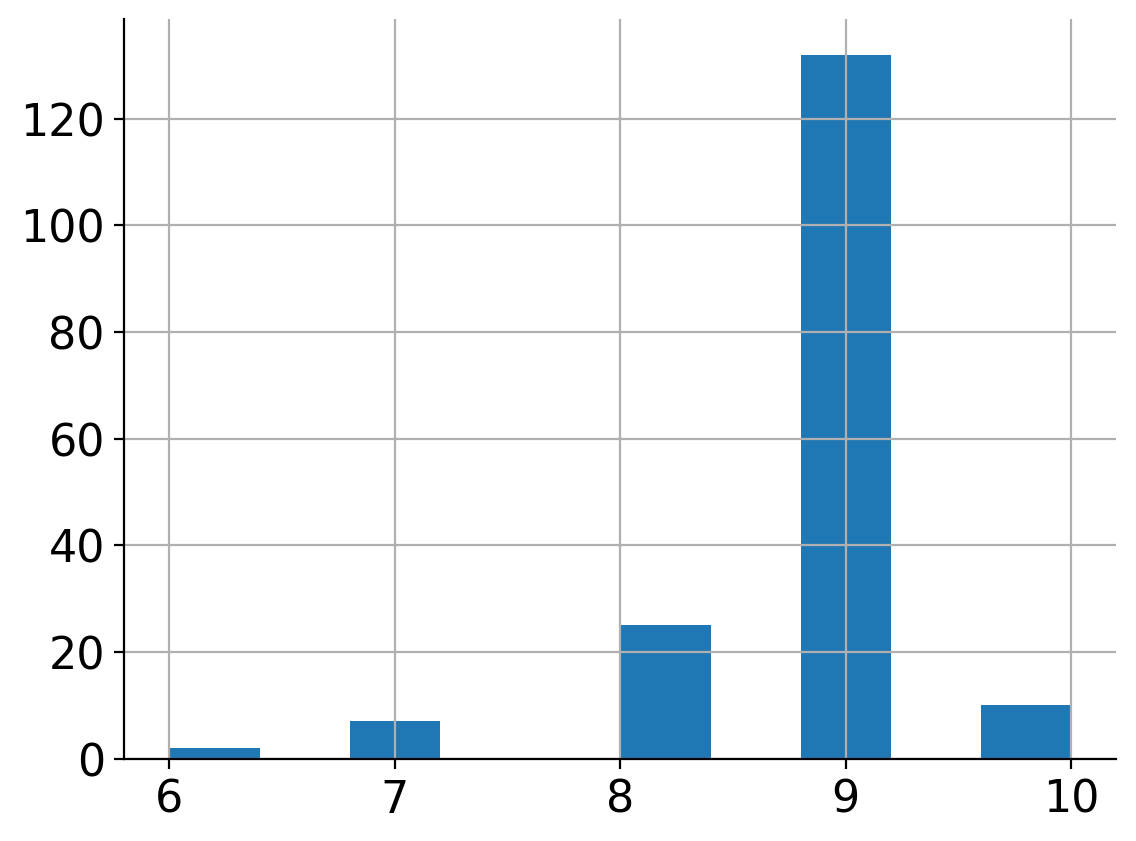

In [11]:
#Number of records per patient
train['Patient'].value_counts().hist()

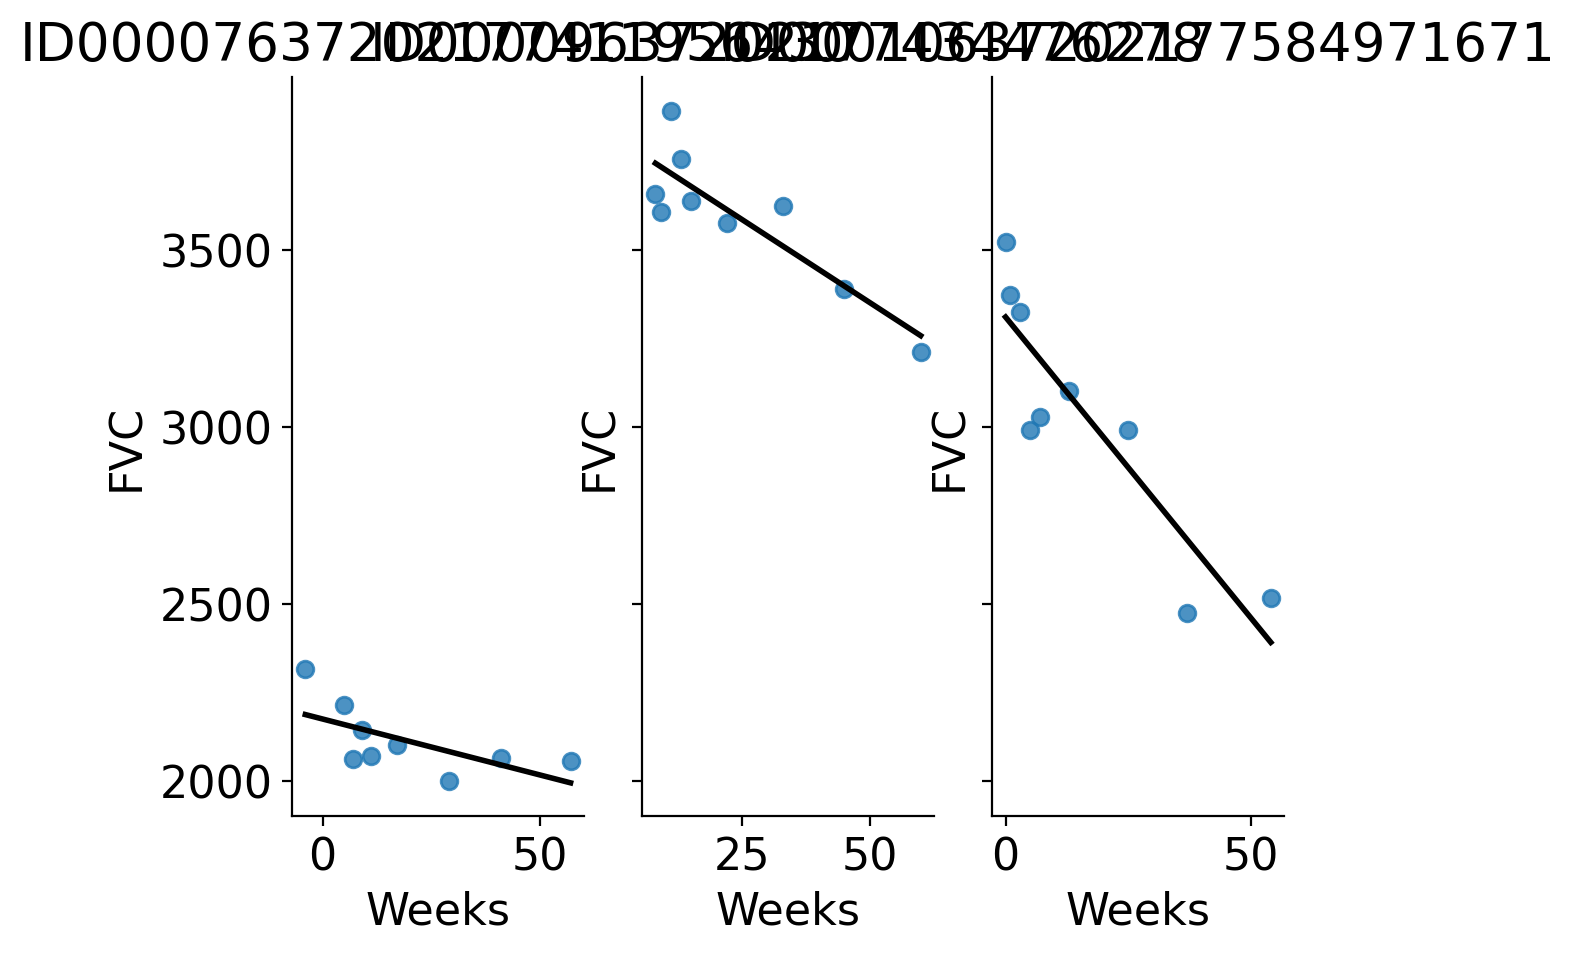

In [12]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "black", "lw":2})


f, axes = plt.subplots(1, 3, sharey=True)
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

In [13]:
try:
    import numpyro
except ImportError:
    %pip install numpyro
    import numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.3 MB/s eta 0:00:00


In [14]:
import numpyro.distributions as dist

### Vanilla Linear Regression

In [15]:
sample_weeks = train["Weeks"].values
sample_fvc = train["FVC"].values

In [16]:
### Linear regression from scikit-learn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(sample_weeks.reshape(-1, 1), sample_fvc)

LinearRegression()

In [17]:
all_weeks = np.arange(-12, 134, 1)

Text(0, 0.5, 'FVC')

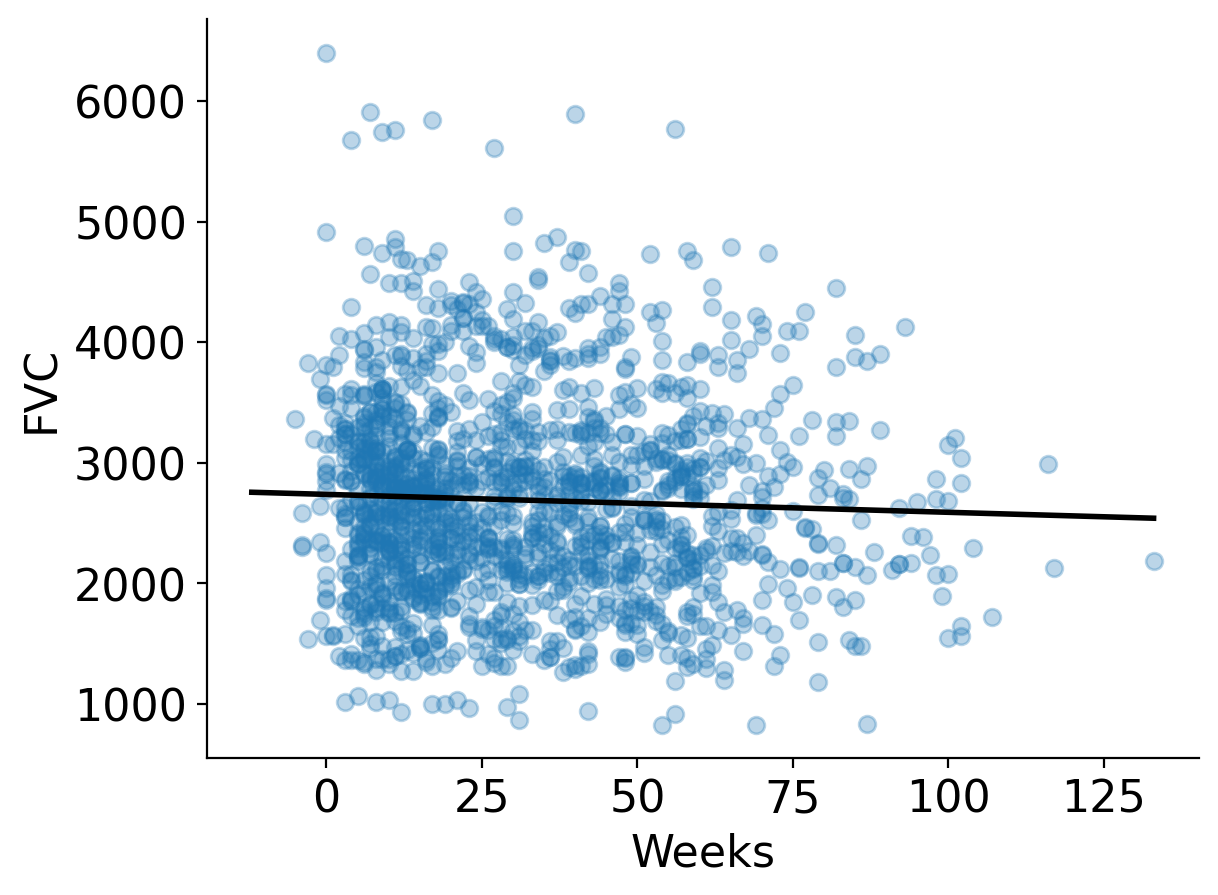

In [18]:
# Plot the data and the regression line
plt.scatter(sample_weeks, sample_fvc, alpha=0.3)
plt.plot(all_weeks, lr.predict(all_weeks.reshape(-1, 1)), color="black", lw=2)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [19]:
lr.coef_, lr.intercept_

(array([-1.48471319]), 2737.784722381955)

In [20]:
# Finding the mean absolute error

from sklearn.metrics import mean_absolute_error

maes = {}
maes["LinearRegression"] = mean_absolute_error(sample_fvc, lr.predict(sample_weeks.reshape(-1, 1)))
maes

{'LinearRegression': 654.8103093180237}

### Pooled model

$\alpha \sim \text{Normal}(0, 1)$

$\beta \sim \text{Normal}(0, 1)$

$\sigma \sim \text{HalfNormal}(100)$

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha + \beta \cdot Week_i, \sigma)$



In [21]:
def pooled_model(sample_weeks, sample_fvc):
    α = numpyro.sample("α", dist.Normal(0., 500.))
    β = numpyro.sample("β", dist.Normal(0., 500.))
    σ = numpyro.sample("σ", dist.HalfNormal(50.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", dist.Normal(α + β * sample_weeks, σ), obs=sample_fvc)
    return fvc

In [22]:
sample_weeks.shape

(1549,)

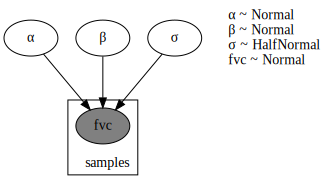

In [23]:
# Render the model graph
numpyro.render_model(pooled_model, model_kwargs={"sample_weeks": sample_weeks, "sample_fvc": sample_fvc},
                render_distributions=True,
                render_params=True,
                )

In [24]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

In [25]:
sample_patient_code = train["patient_code"].values

In [26]:
sample_patient_code

array([  0,   0,   0, ..., 175, 175, 175])

In [27]:
from numpyro.infer import MCMC, NUTS, Predictive

In [28]:

nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)


In [29]:
mcmc.run(rng_key, sample_weeks=sample_weeks, sample_fvc=sample_fvc)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 6000/6000 [00:05<00:00, 1079.38it/s, 7 steps of size 5.24e-01. acc. prob=0.88]


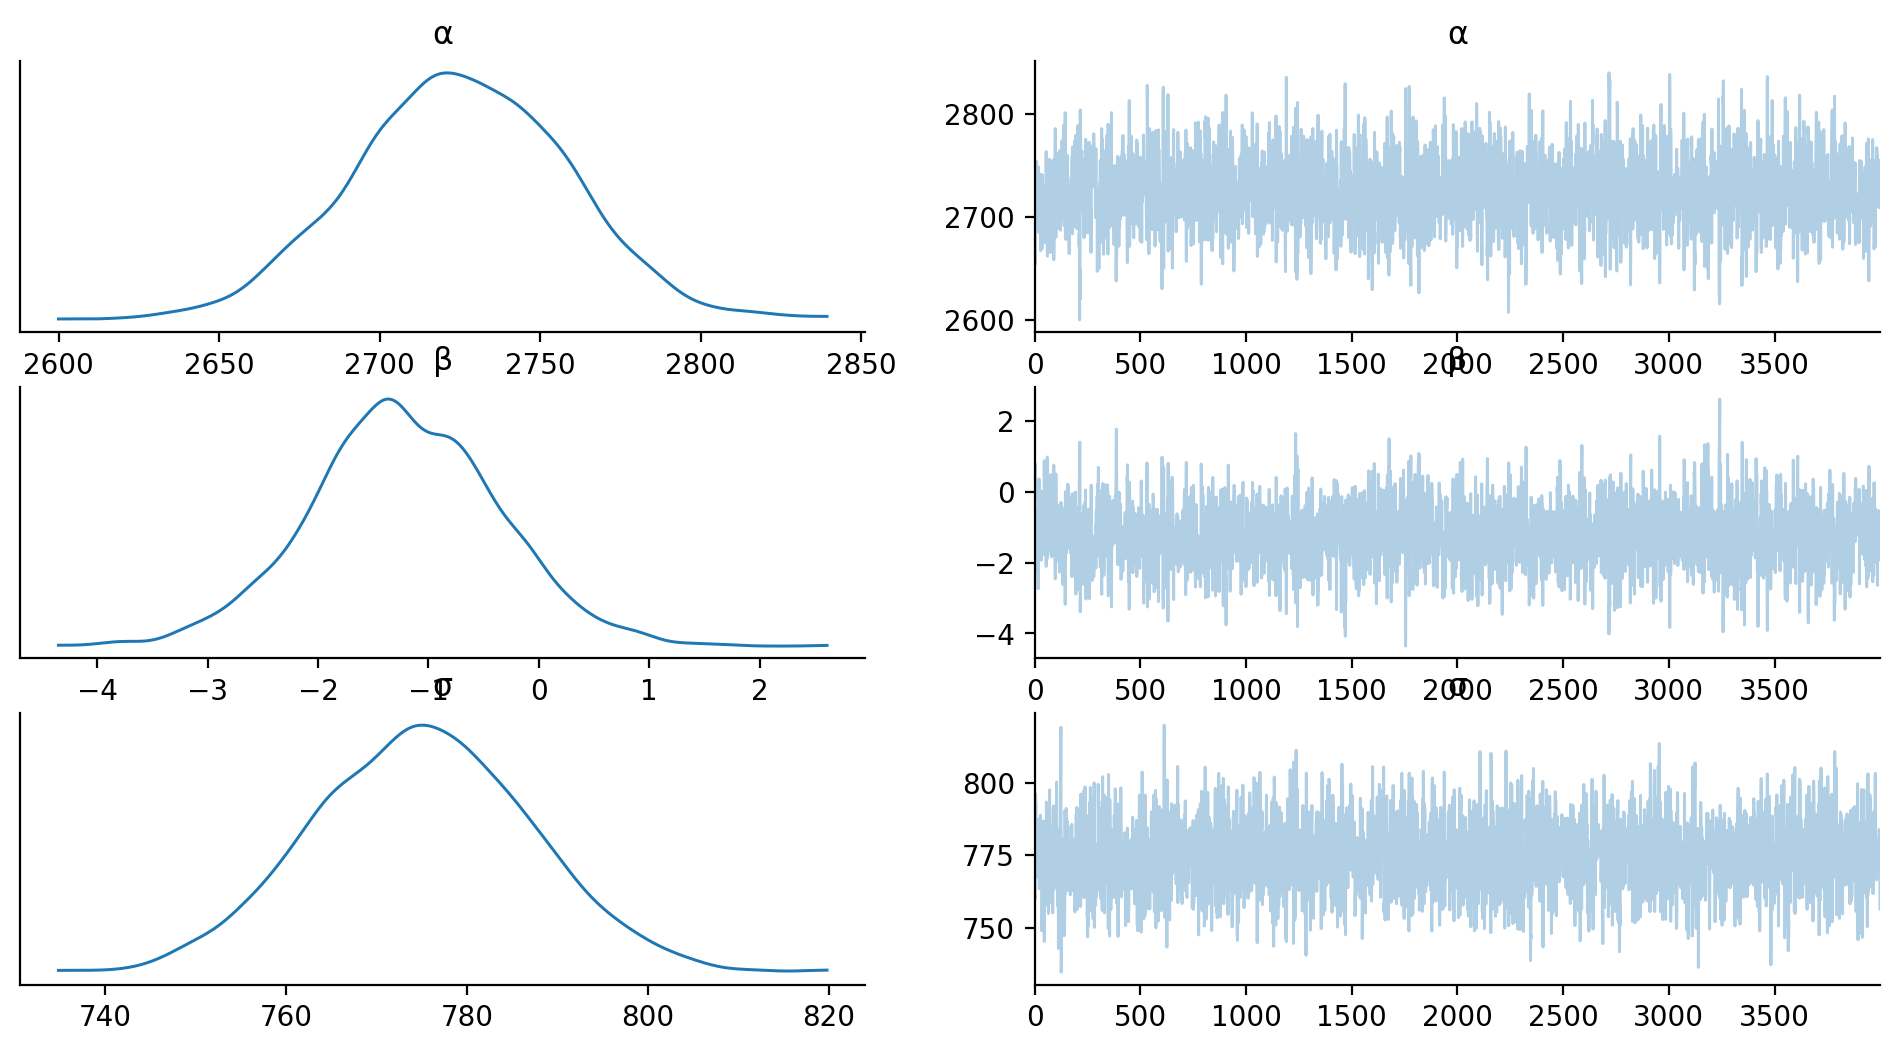

In [30]:
import arviz as az

idata = az.from_numpyro(mcmc)
az.plot_trace(idata, compact=True);

In [31]:
# Summary statistics
az.summary(idata, round_to=2)

Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α  2724.98  33.46  2663.52  2786.90       0.74     0.52   2052.67   1952.52   
β    -1.22   0.85    -2.80     0.43       0.02     0.01   1955.95   2019.17   
σ   775.05  12.03   752.85   797.95       0.25     0.17   2411.55   2720.36   

   r_hat  
α    NaN  
β    NaN  
σ    NaN

In [32]:
# Predictive distribution
predictive = Predictive(pooled_model, mcmc.get_samples())

In [33]:
predictive

In [34]:
predictions = predictive(rng_key, all_weeks, None)

<Axes: >

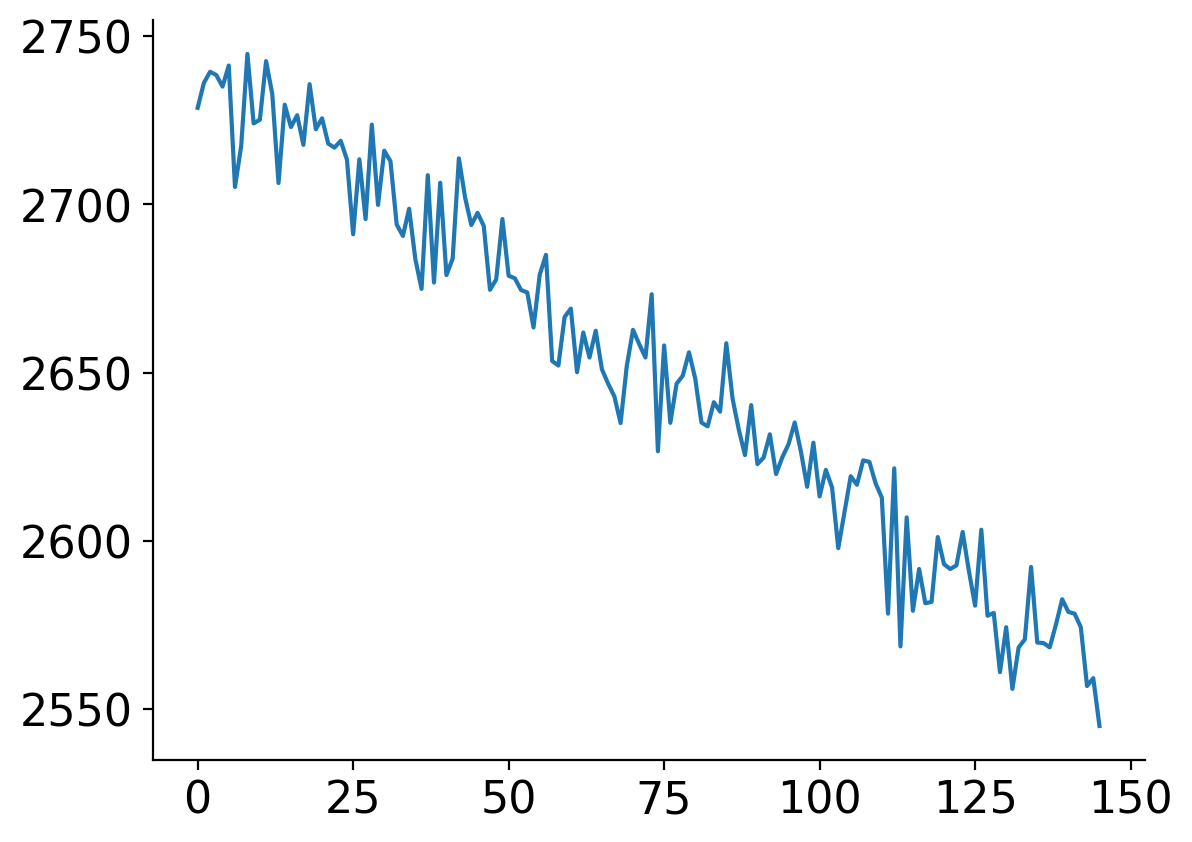

In [35]:
pd.DataFrame(predictions["fvc"]).mean().plot()

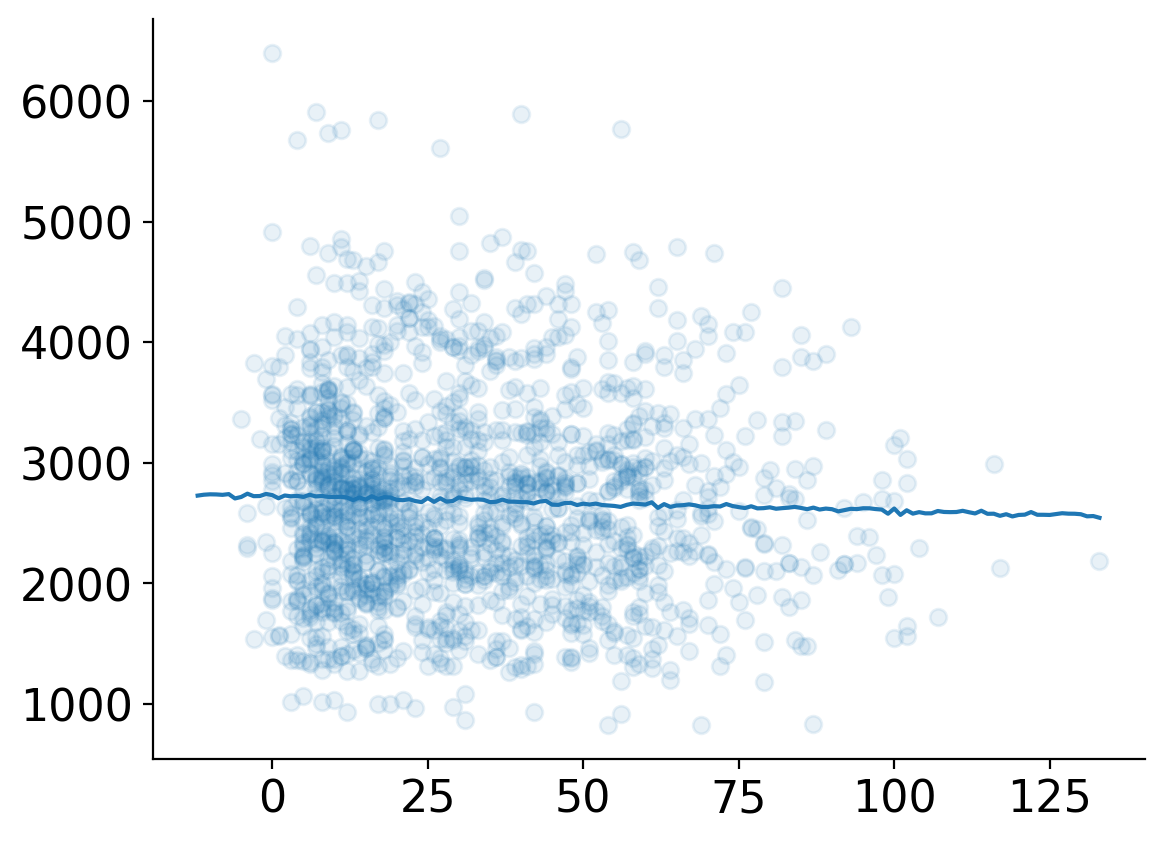

In [36]:
plt.plot(all_weeks, predictions["fvc"].mean(axis=0))
plt.scatter(sample_weeks, sample_fvc, alpha=0.1)

Text(0, 0.5, 'FVC')

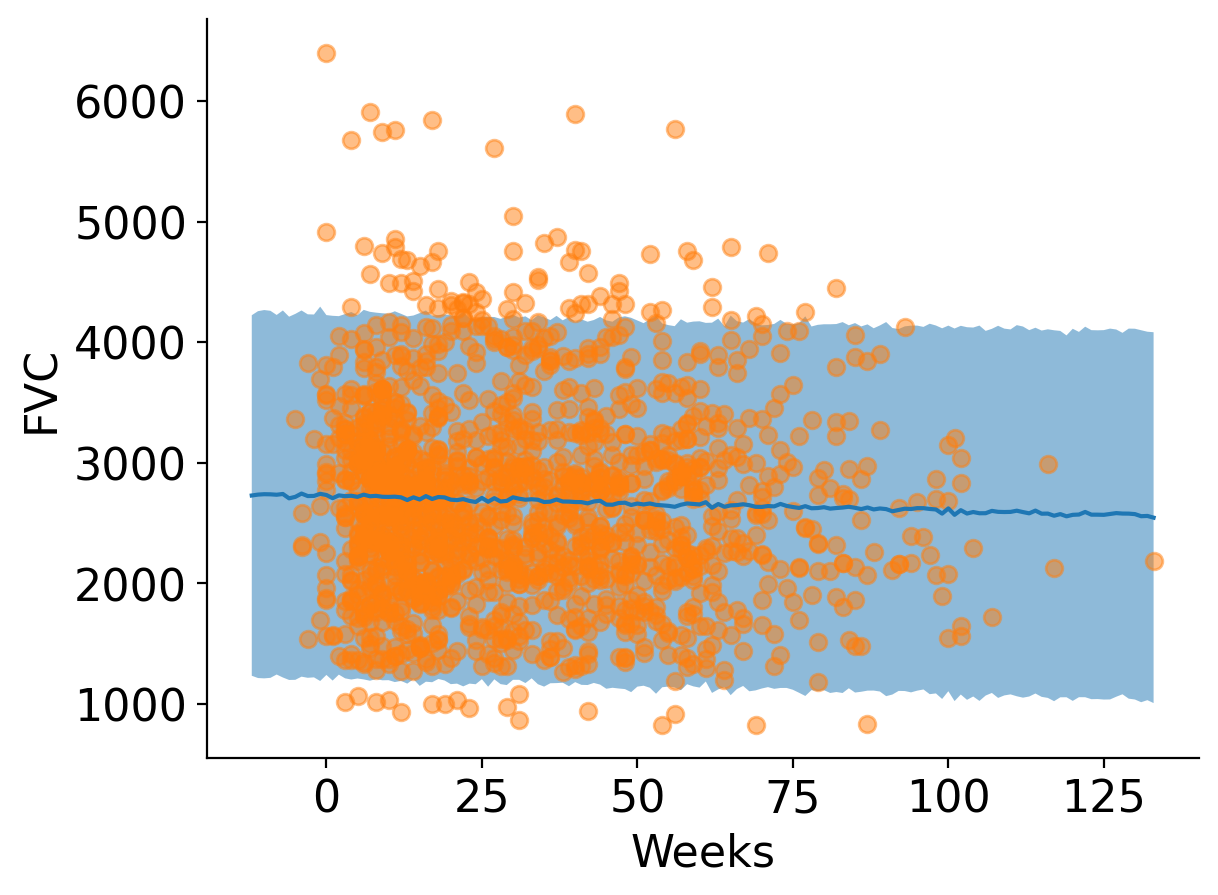

In [37]:
# Get the mean and standard deviation of the predictions
mu = predictions["fvc"].mean(axis=0)
sigma = predictions["fvc"].std(axis=0)

# Plot the predictions
plt.plot(all_weeks, mu)
plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.5)
plt.scatter(sample_weeks, sample_fvc, alpha=0.5)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [38]:
preds_pooled  = predictive(rng_key, sample_weeks, None)['fvc']
predictions_train_pooled = preds_pooled.mean(axis=0)
std_train_pooled = preds_pooled.std(axis=0)

In [39]:
### Computing Mean Absolute Error and Coverage at 95% confidence interval

maes["PooledModel"] = mean_absolute_error(sample_fvc, predictions_train_pooled)
maes

{'LinearRegression': 654.8103093180237, 'PooledModel': 654.6283571306085}

In [40]:
### Computing the coverage at 95% confidence interval

def coverage(y_true, y_pred, sigma):
    lower = y_pred - 1.96 * sigma
    upper = y_pred + 1.96 * sigma
    return np.mean((y_true >= lower) & (y_true <= upper))
coverages = {}
coverages["pooled"] = coverage(sample_fvc, predictions_train_pooled, std_train_pooled).item()
coverages

{'pooled': 0.9399612545967102}

The above numbers are comparable, which is a good sign. Let's see if we can do better with a personalised model.

### Unpooled Model

$\sigma \sim \text{HalfNormal}(20)$

---

`for p in range(N_patients):`

$\alpha_p \sim \text{Normal}(0, 500)$

$\beta_p \sim \text{Normal}(0, 500)$

---

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha_{p[i]} + \beta_{p[i]} \cdot Week_i, \sigma)$



In [41]:
# Unpooled model
def unpool_model(sample_weeks, sample_patient_code, sample_fvc=None):
    σ = numpyro.sample("σ", dist.HalfNormal(20.))
    with numpyro.plate("patients", sample_patient_code.max() + 1):
        α_p = numpyro.sample("α_p", dist.Normal(0, 500.))
        β_p = numpyro.sample("β_p", dist.Normal(0, 500.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", numpyro.distributions.Normal(α_p[sample_patient_code] +
                                                                 β_p[sample_patient_code] * sample_weeks, σ),
                             obs=sample_fvc)
    return fvc

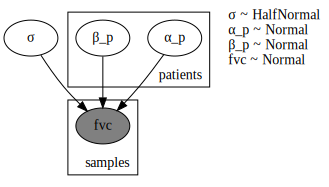

In [42]:
# Render the model graph

model_kwargs = {"sample_weeks": sample_weeks,
                "sample_patient_code": sample_patient_code,
                "sample_fvc": sample_fvc}

numpyro.render_model(unpool_model, model_kwargs=model_kwargs,
                render_distributions=True,
                render_params=True,
                )

In [43]:
nuts_kernel_unpooled = NUTS(unpool_model)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=200, num_warmup=500)
rng_key = random.PRNGKey(0)

In [44]:
model_kwargs

{'sample_weeks': array([-4,  5,  7, ..., 31, 43, 59]),
 'sample_patient_code': array([  0,   0,   0, ..., 175, 175, 175]),
 'sample_fvc': array([2315, 2214, 2061, ..., 2908, 2975, 2774])}

In [45]:
mcmc_unpooled.run(rng_key, **model_kwargs)

posterior_samples = mcmc_unpooled.get_samples()

sample: 100%|██████████| 700/700 [00:13<00:00, 53.38it/s, 63 steps of size 9.00e-02. acc. prob=0.91] 


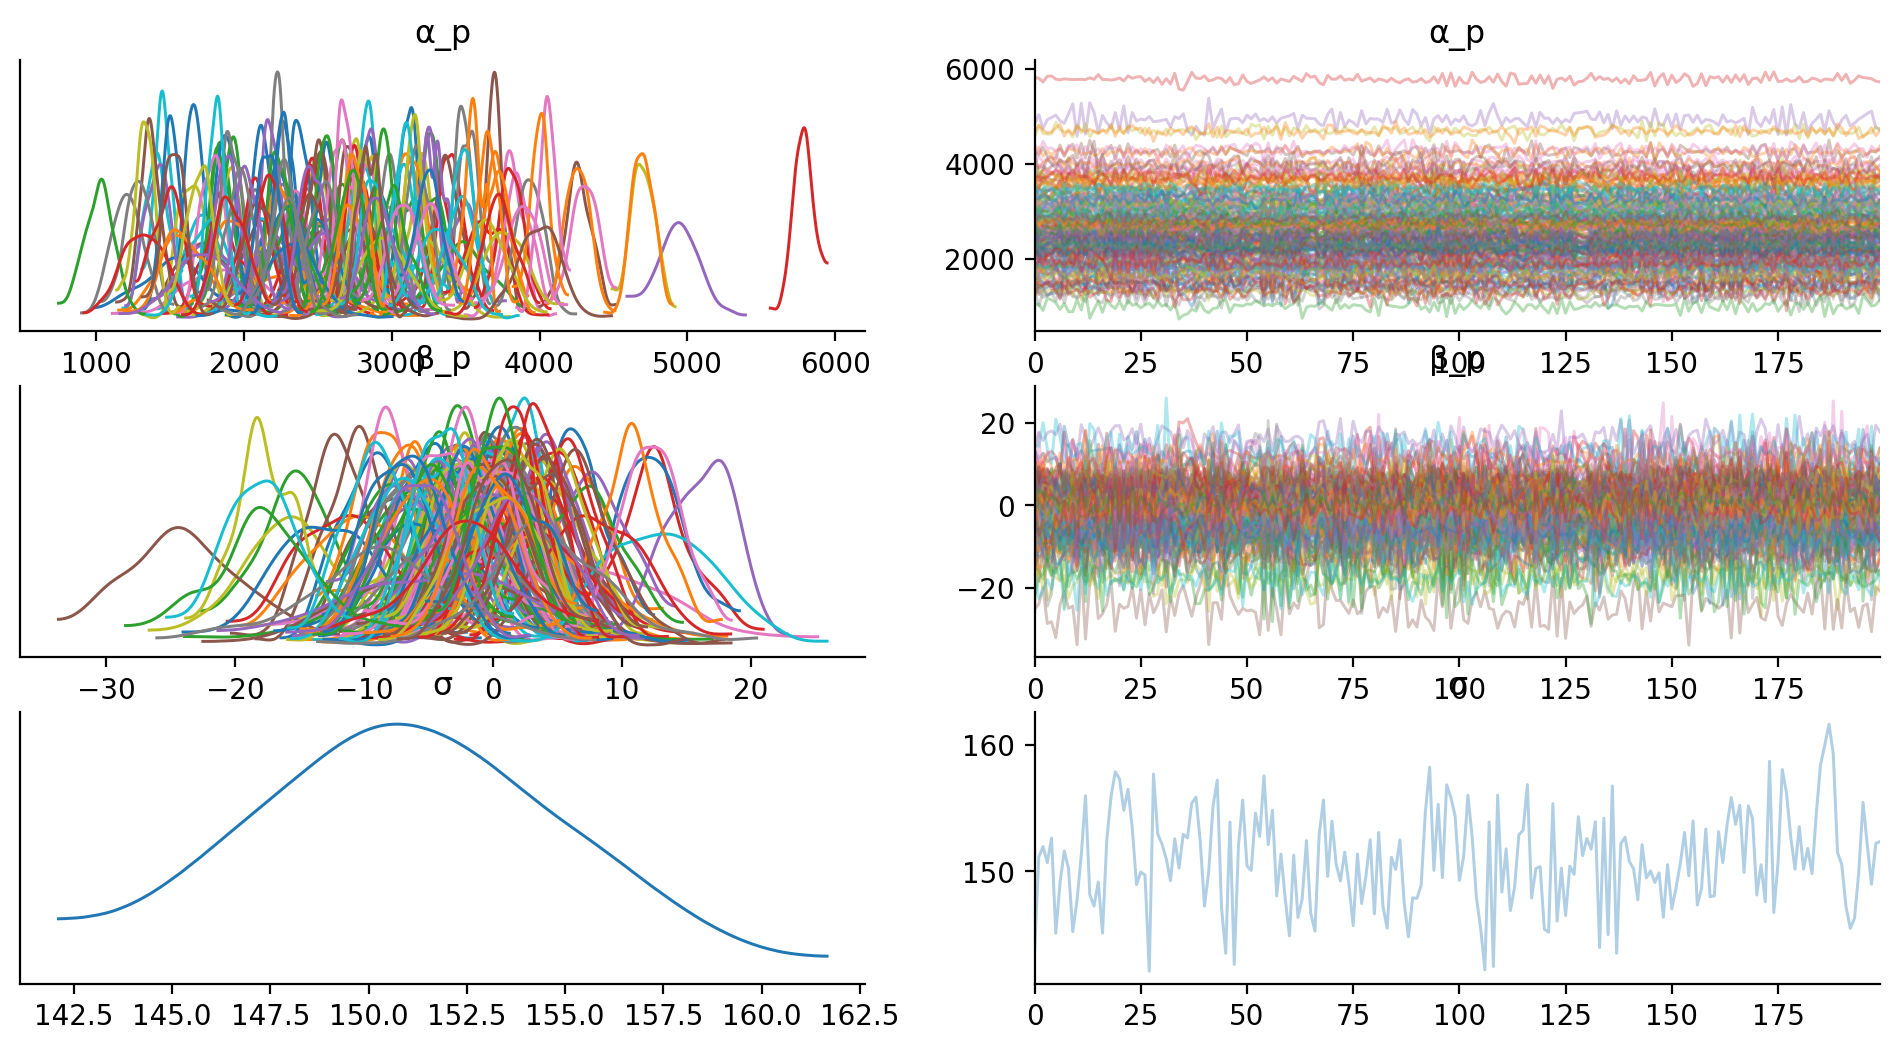

In [46]:
az.plot_trace(az.from_numpyro(mcmc_unpooled), compact=True);

In [47]:
# Predictive distribution for unpooled model

predictive_unpooled = Predictive(unpool_model, mcmc_unpooled.get_samples())

In [48]:
# Predictive distribution for unpooled model for all weeks for a given patient

all_weeks = np.arange(-12, 134, 1)
def predict_unpooled(patient_code):
    predictions = predictive_unpooled(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient(patient_code):
    mu, sigma = predict_unpooled(patient_code)
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform(patient_code)[0]
    patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.title(id_to_patient)

In [49]:
plot_pooled = True

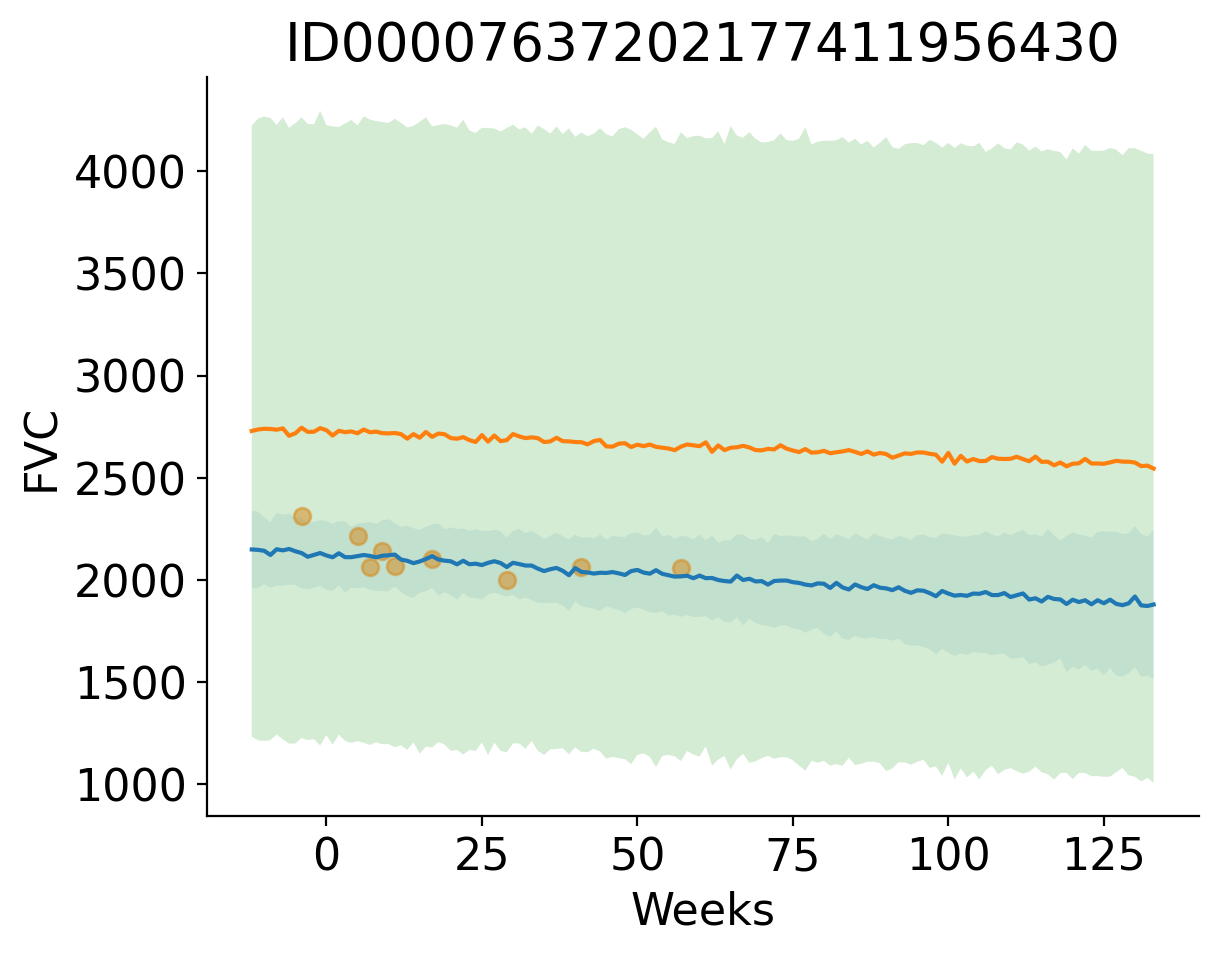

In [50]:
plot_patient(np.array([0]))
if plot_pooled:
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2)

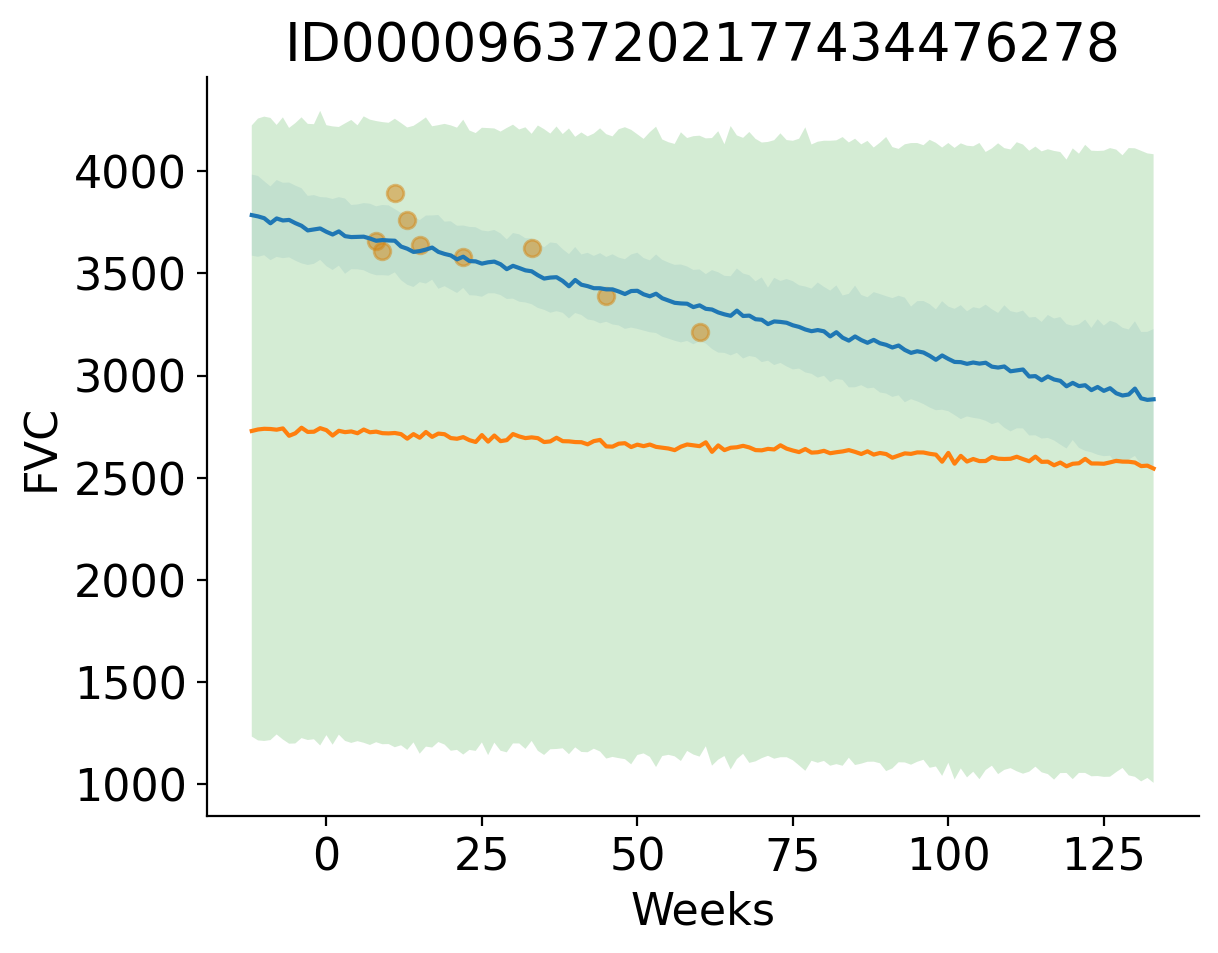

In [51]:
plot_patient(np.array([1]))
if plot_pooled:
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2)

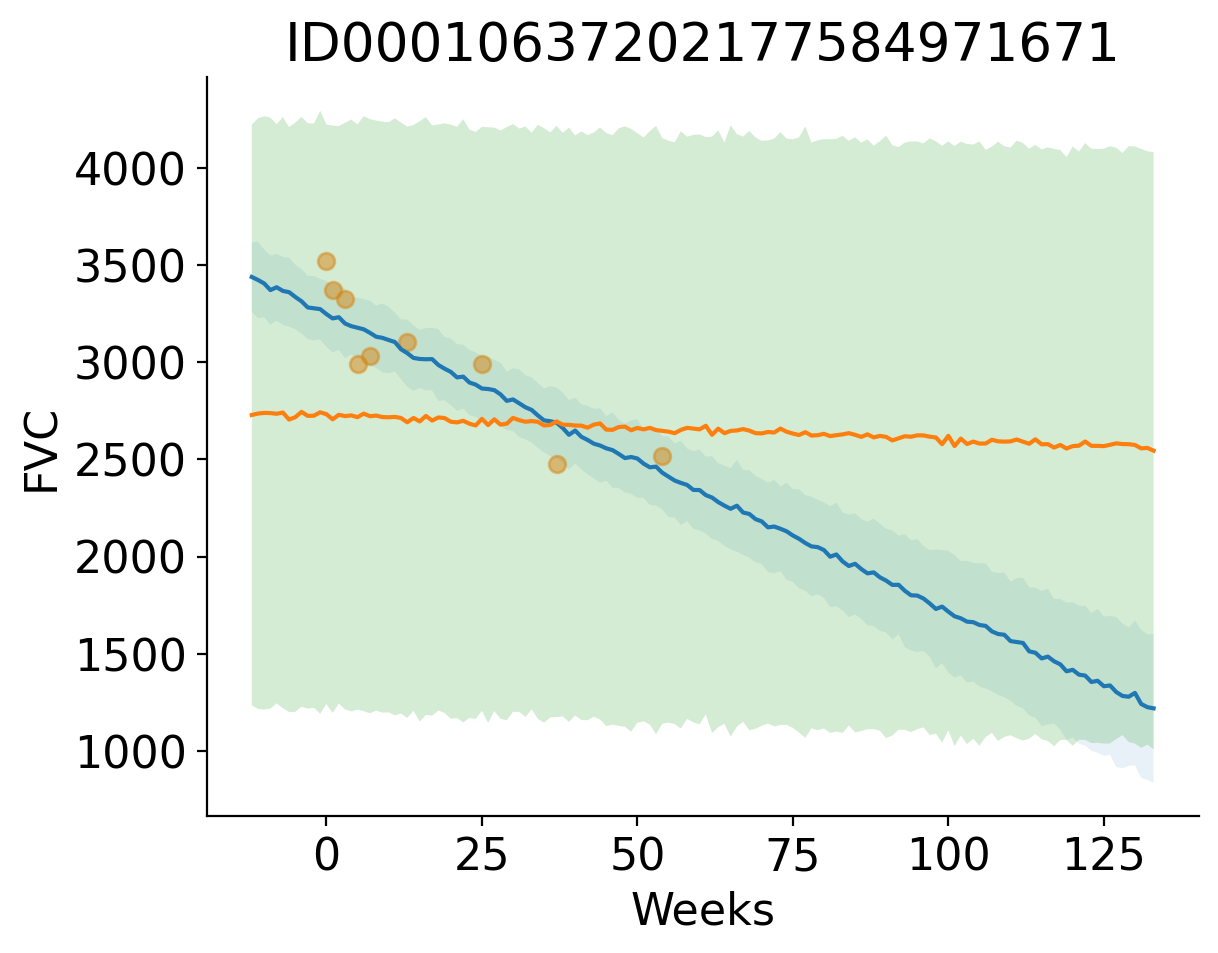

In [52]:
plot_patient(np.array([2]))
if plot_pooled:
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2)

Computing metrics on the training set for unpool_model

In [53]:

predictions_train_unpooled = predictive_unpooled(rng_key,
                                                 sample_weeks,
                                                 train["patient_code"].values)['fvc']
predictions_train_unpooled.shape

(200, 1549)

In [54]:
mu_predictions_train_unpooled = predictions_train_unpooled.mean(axis=0)
std_predictions_train_unpooled = predictions_train_unpooled.std(axis=0)

maes["UnpooledModel"] = mean_absolute_error(sample_fvc, mu_predictions_train_unpooled)
maes

{'LinearRegression': 654.8103093180237,
 'PooledModel': 654.6283571306085,
 'UnpooledModel': 98.18583518632232}

In [55]:
coverages["unpooled"] = coverage(sample_fvc, mu_predictions_train_unpooled, std_predictions_train_unpooled).item()
coverages

{'pooled': 0.9399612545967102, 'unpooled': 0.974822461605072}

### Exercise: Another variation of unpooled model

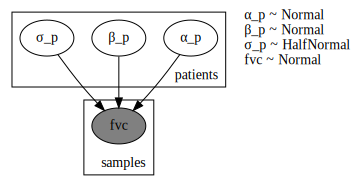

In [56]:
# Unpooled model
def unpool_model_var(sample_weeks, sample_patient_code, sample_fvc=None):
    with numpyro.plate("patients", sample_patient_code.max() + 1):
        α_p = numpyro.sample("α_p", dist.Normal(0, 500.))
        β_p = numpyro.sample("β_p", dist.Normal(0, 500.))
        σ_p = numpyro.sample("σ_p", dist.HalfNormal(20.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", numpyro.distributions.Normal(α_p[sample_patient_code] +
                                                                 β_p[sample_patient_code] * sample_weeks,
                                                                 σ_p[sample_patient_code]),
                             obs=sample_fvc)
    return fvc

# Plot graphical model
numpyro.render_model(unpool_model_var, model_kwargs=model_kwargs,
                render_distributions=True,
                render_params=True,
                )


In [57]:
nuts_kernel_unpooled_2 = NUTS(unpool_model_var)

mcmc_unpooled_2 = MCMC(nuts_kernel_unpooled_2, num_samples=400, num_warmup=500)
rng_key = random.PRNGKey(0)

mcmc_unpooled_2.run(rng_key, **model_kwargs)

posterior_samples_2 = mcmc_unpooled_2.get_samples()

sample: 100%|██████████| 900/900 [00:10<00:00, 87.67it/s, 63 steps of size 8.17e-02. acc. prob=0.88] 


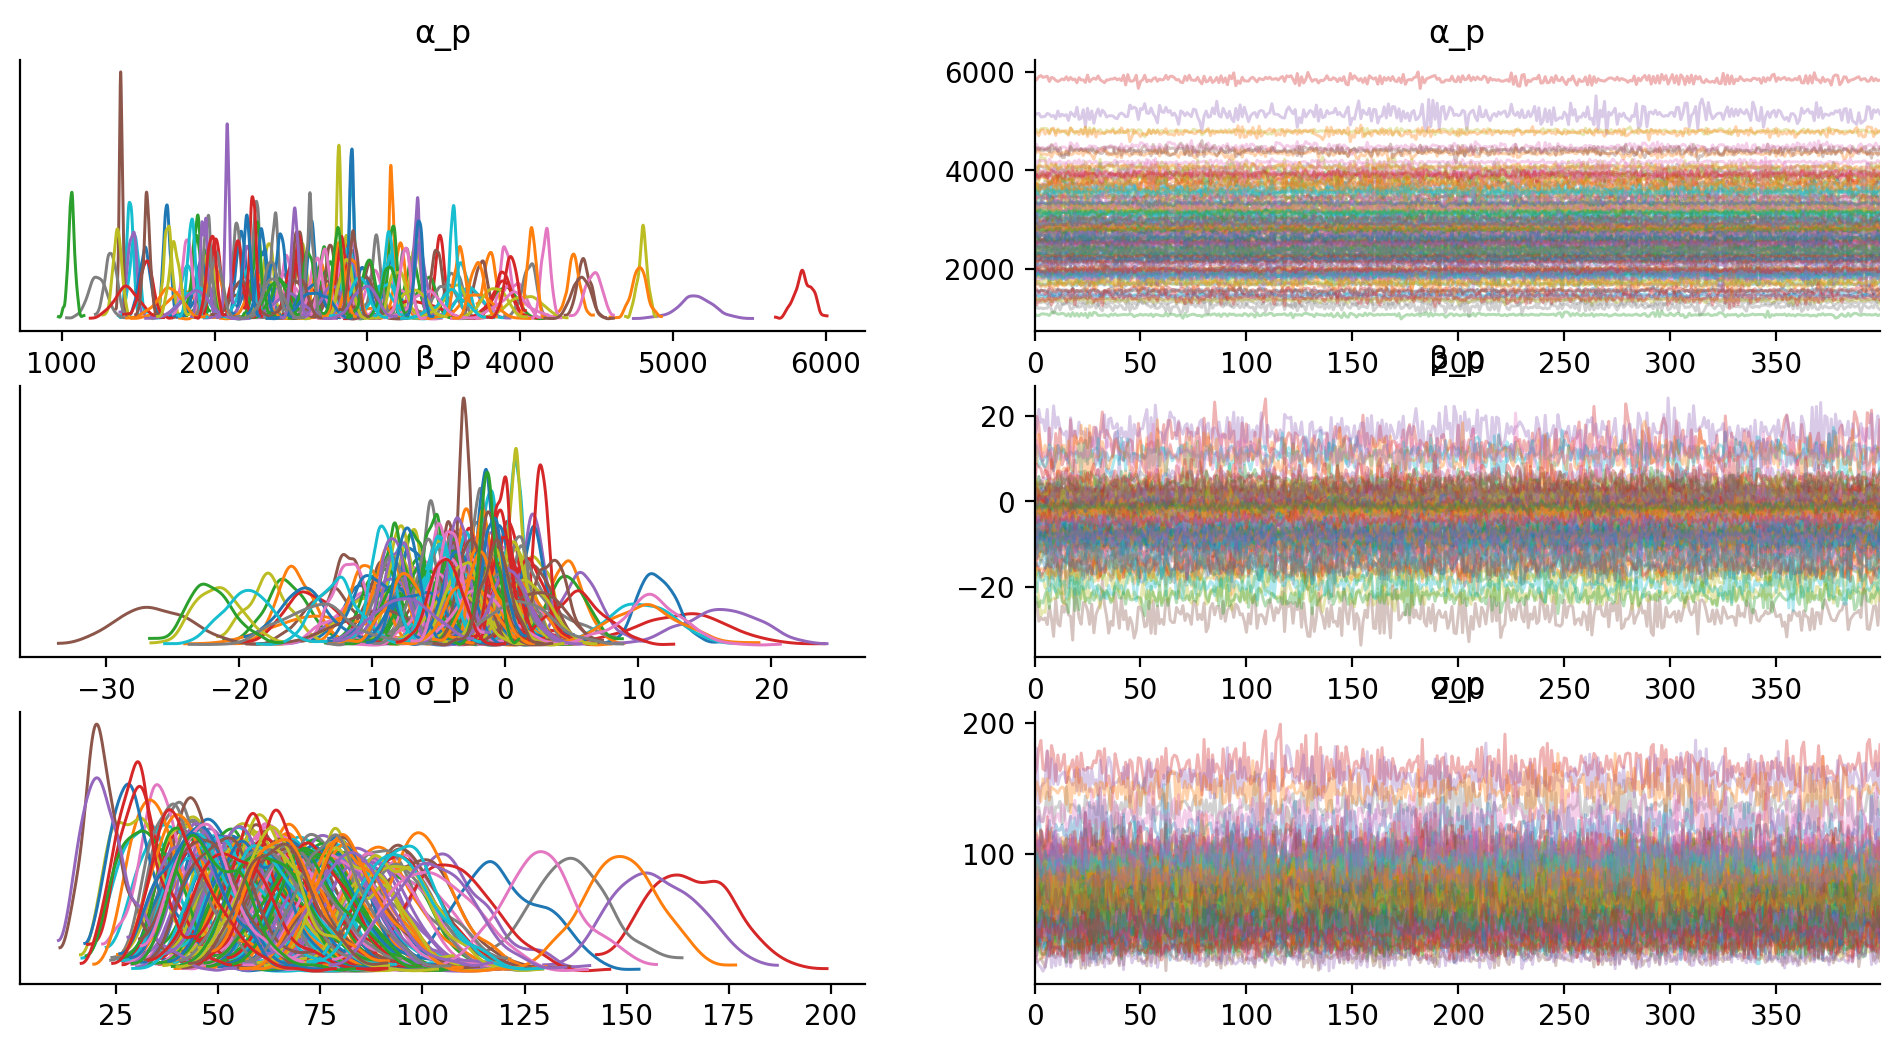

In [58]:
az.plot_trace(az.from_numpyro(mcmc_unpooled_2), compact=True);

In [59]:
# Predictive distribution for unpooled model variation 2

predictive_unpooled_2 = Predictive(unpool_model_var, mcmc_unpooled_2.get_samples())


In [60]:
predictions_train_unpooled_2 = predictive_unpooled_2(rng_key,
                                                        sample_weeks,
                                                        train["patient_code"].values)['fvc']

mu_predictions_train_unpooled_2 = predictions_train_unpooled_2.mean(axis=0)
std_predictions_train_unpooled_2 = predictions_train_unpooled_2.std(axis=0)

maes["UnpooledModel2"] = mean_absolute_error(sample_fvc, mu_predictions_train_unpooled_2)

coverages["unpooled2"] = coverage(sample_fvc, mu_predictions_train_unpooled_2, std_predictions_train_unpooled_2).item()

print(maes)
print(coverages)

{'LinearRegression': 654.8103093180237, 'PooledModel': 654.6283571306085, 'UnpooledModel': 98.18583518632232, 'UnpooledModel2': 81.93005607511398}
{'pooled': 0.9399612545967102, 'unpooled': 0.974822461605072, 'unpooled2': 0.886378288269043}


### Hierarchical model

$\sigma \sim \text{HalfNormal}(100)$

---

$\mu_{\alpha} \sim \text{Normal}(0, 500)$

$\sigma_{\alpha} \sim \text{HalfNormal}(100)$

$\mu_{\beta} \sim \text{Normal}(0, 500)$

$\sigma_{\beta} \sim \text{HalfNormal}(100)$

---

`for p in range(N_patients):`

$\alpha_p \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$

$\beta_p \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$

---

`for i in range(N_Weeks):`

$FVC_i \sim \text{Normal}(\alpha_{p[i]} + \beta_{p[i]} \cdot Week_i, \sigma)$


In [61]:
### Hierarchical model

def final_model(sample_weeks, sample_patient_code, sample_fvc=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(sample_patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[sample_patient_code] + β[sample_patient_code] * sample_weeks

    with numpyro.plate("data", len(sample_patient_code)):
        numpyro.sample("fvc", dist.Normal(FVC_est, σ), obs=sample_fvc)

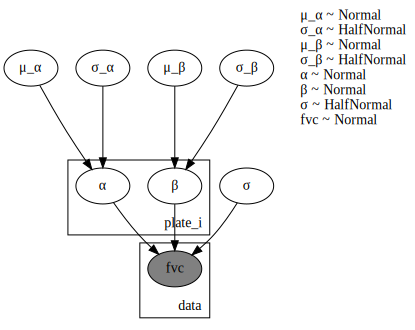

In [62]:
# Render the model graph


numpyro.render_model(final_model, model_kwargs=model_kwargs,
                render_distributions=True,
                render_params=True,
                )


In [63]:
nuts_final = NUTS(final_model)

mcmc_final = MCMC(nuts_final, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

In [64]:
mcmc_final.run(rng_key, **model_kwargs)

sample: 100%|██████████| 6000/6000 [00:55<00:00, 108.08it/s, 63 steps of size 1.04e-02. acc. prob=0.84]


In [65]:
predictive_final = Predictive(final_model, mcmc_final.get_samples())

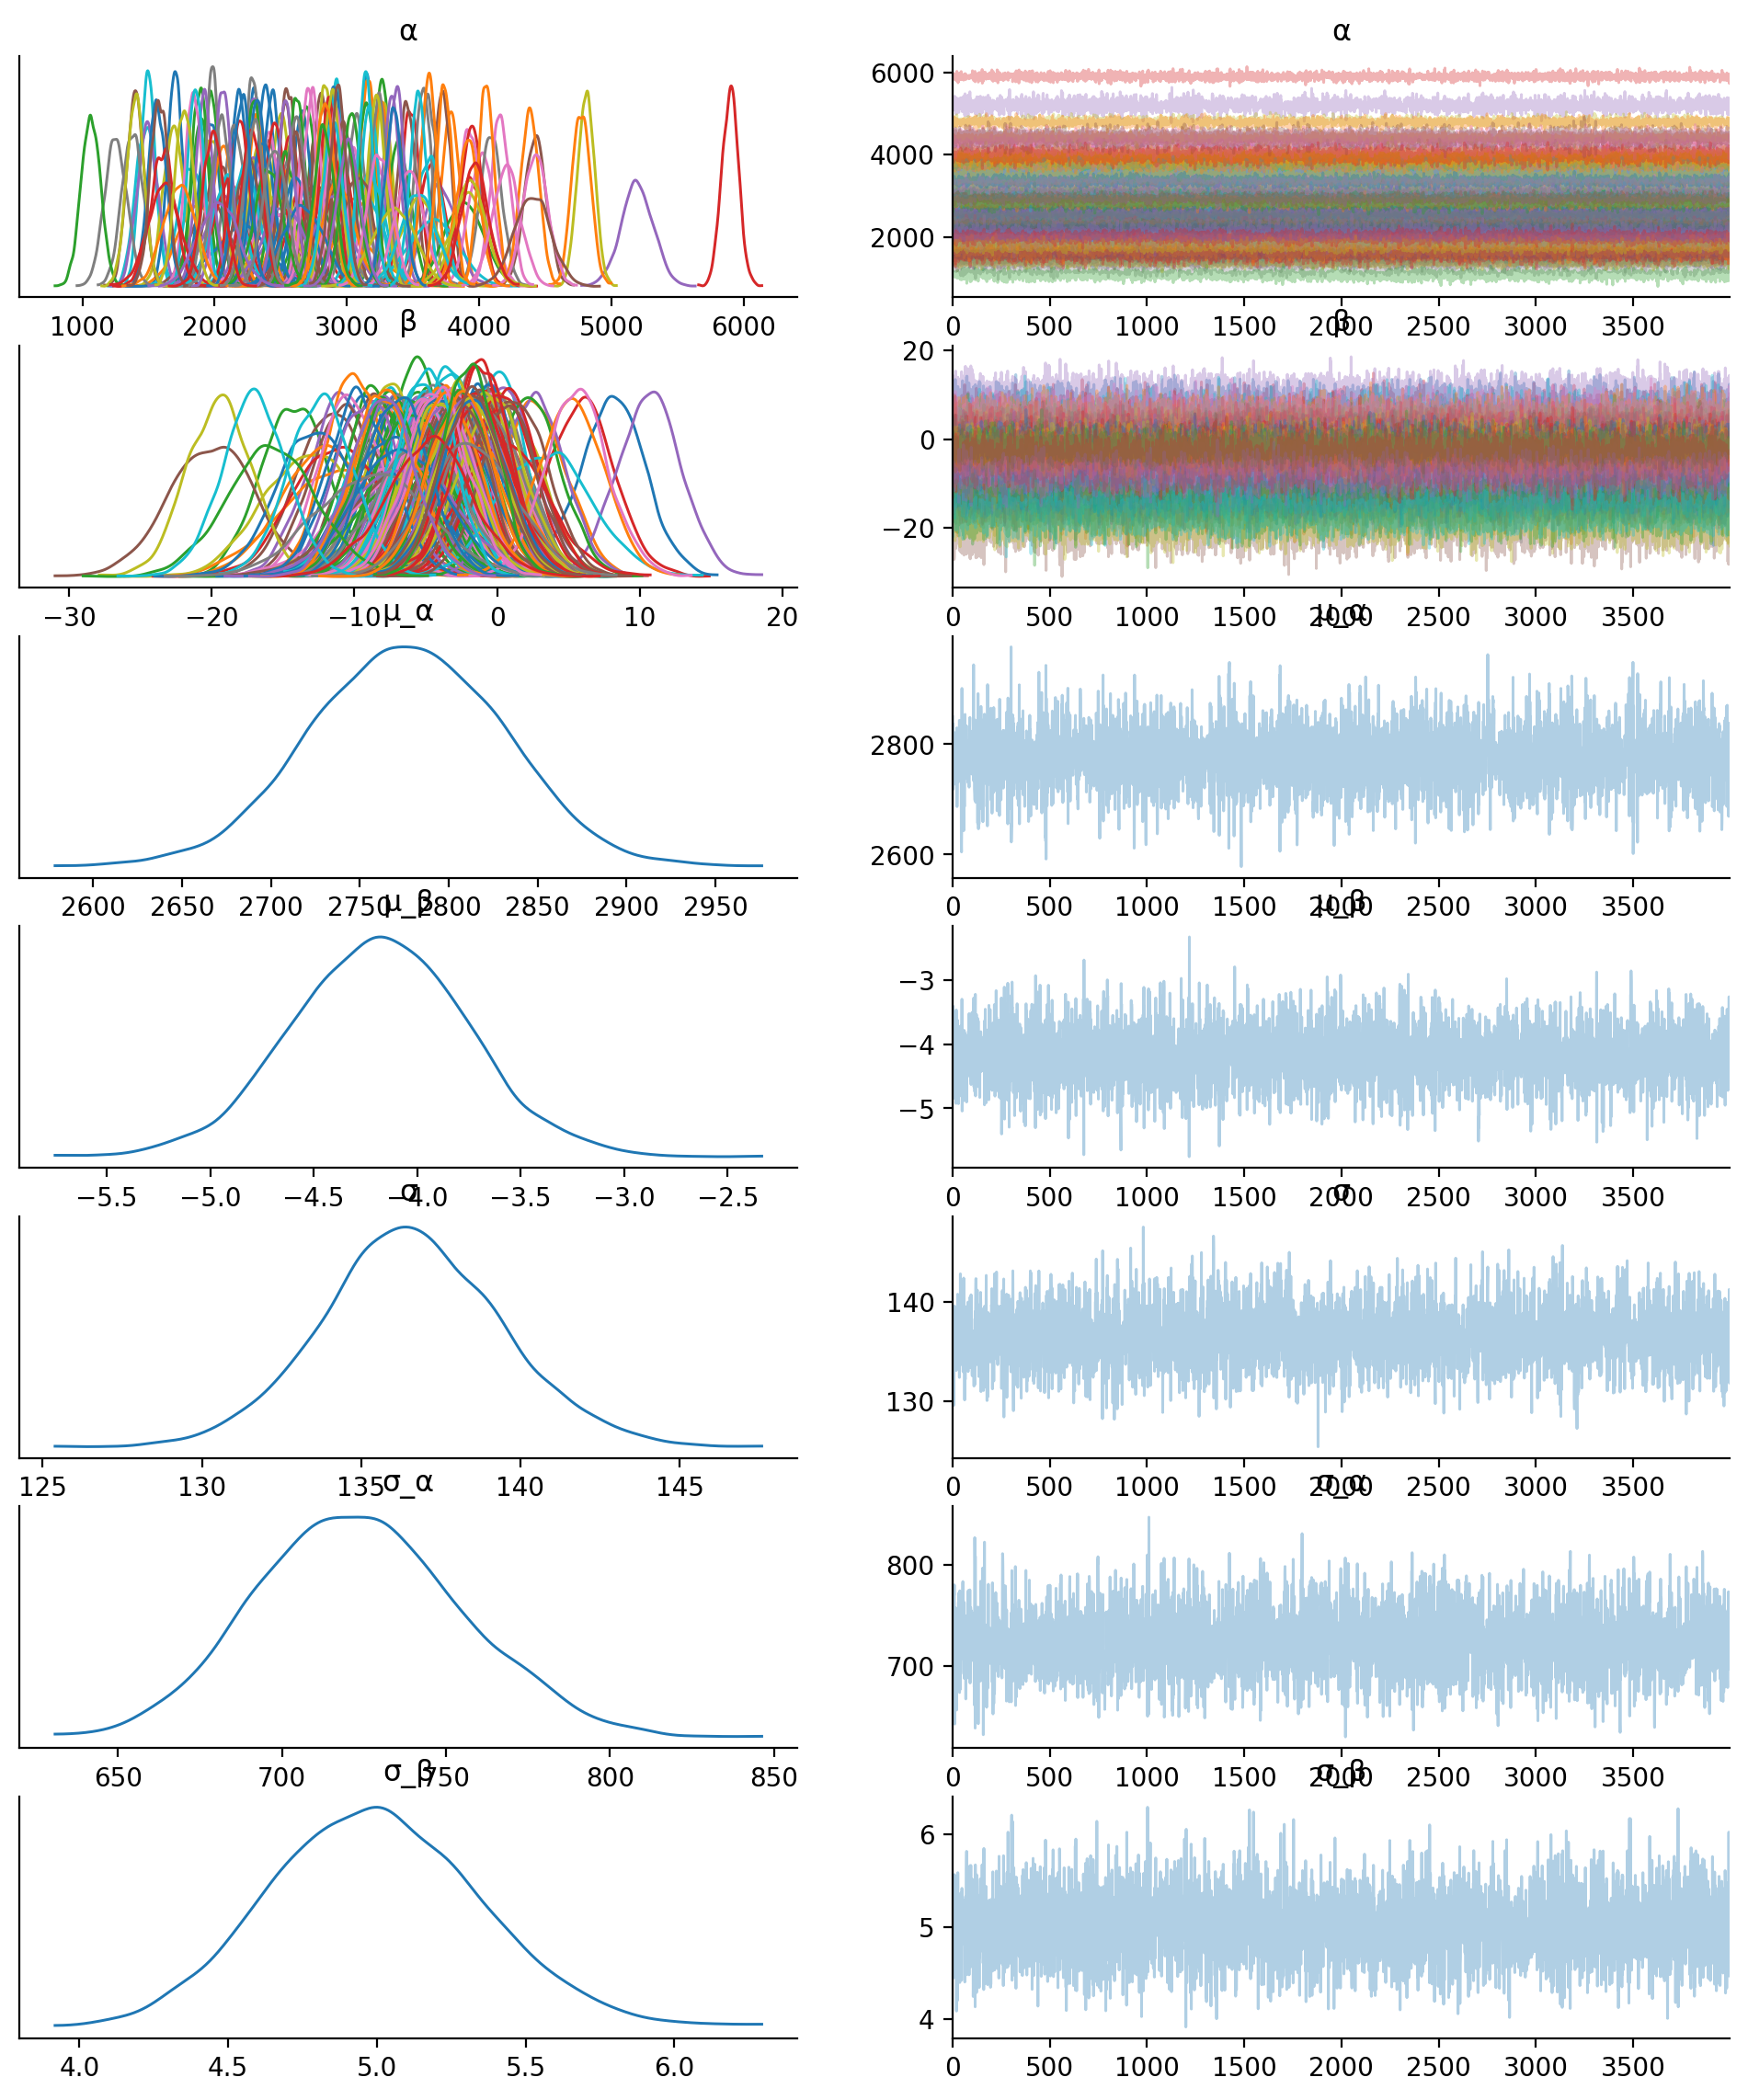

In [66]:
az.plot_trace(az.from_numpyro(mcmc_final), compact=True);

In [67]:
# Predict for a given patient


def predict_final(patient_code):
    predictions = predictive_final(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_final(patient_code):
    mu, sigma = predict_final(patient_code)
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.5)
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

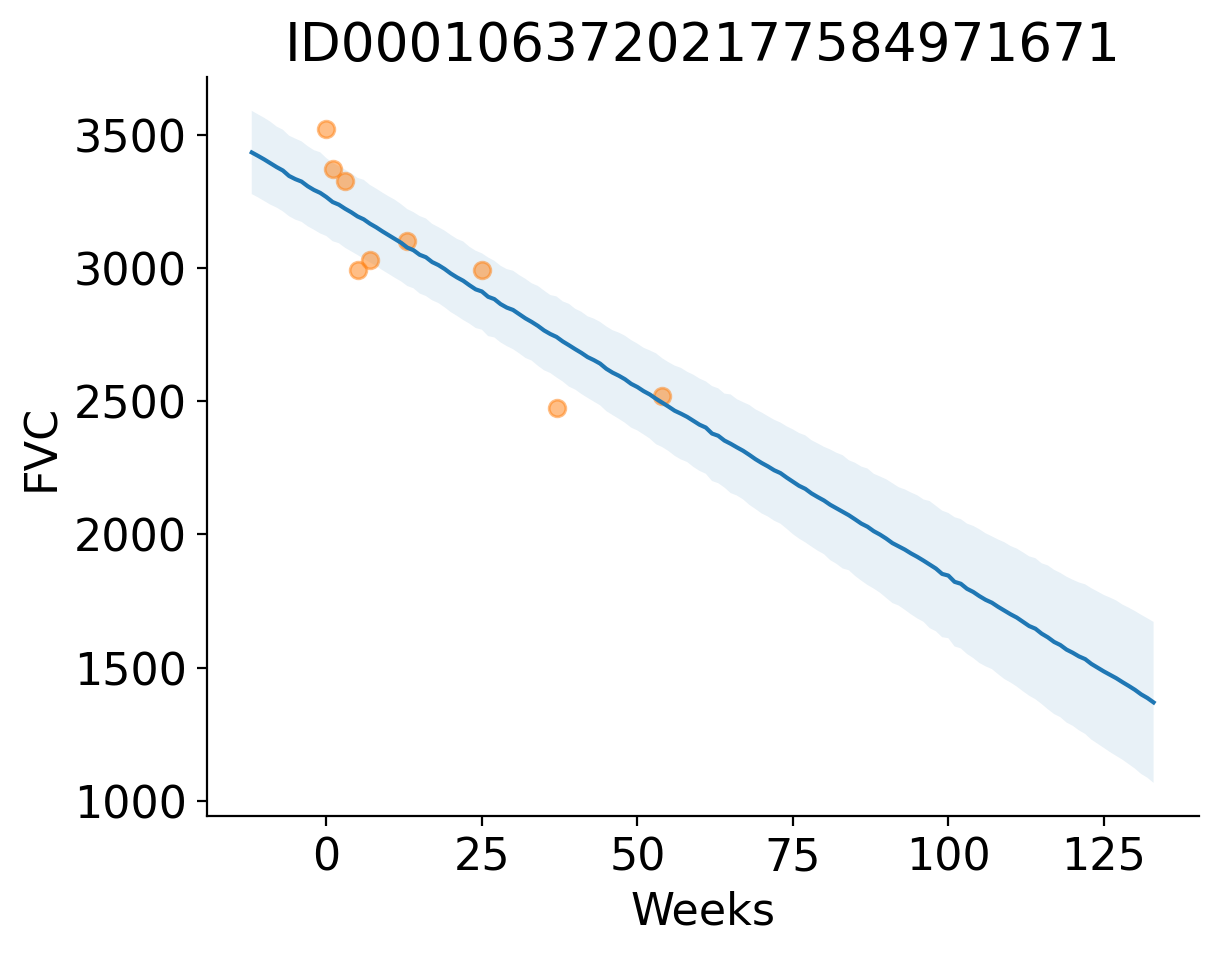

In [68]:
# plot for a given patient
plot_patient_final(np.array([2]))